In [2]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models import VGG19_Weights

import numpy as np
import matplotlib.pyplot as plt
from imageio.v2 import imread

from torch.nn.modules.conv import Conv2d

In [15]:
class VGGNet():
    img_dim = 256
    mean_arr = [0.485, 0.456, 0.406]
    std_arr = [0.229, 0.224, 0.225]

    def __init__(self):
        self.model = torchvision.models.vgg19(pretrained=True)
        self.is_frozen = False

    def freeze_model(self, freeze=False):
        for p in self.model.parameters():
            p.requires_grad_(freeze)

        self.is_frozen = ~ self.is_frozen

    def switch_to_eval(self, eval=True):
        self.model.eval() if eval else self.model.train()

    def switch_device(self, name):
        self.model.to(name)

    def __str__(self):
        return self.model.__str__()

    @staticmethod
    def get_image_transform():
        transform = T.Compose([
            T.ToTensor(),
            T.Resize(VGGNet.img_dim, antialias=False),
            T.Normalize(mean=VGGNet.mean_arr, std=VGGNet.std_arr)
        ])

        return transform

In [16]:
def get_images(visualize=False) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
  content_img_link = 'https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg'
  style_img_link = 'https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg'

  content_img = imread( content_img_link )
  style_img = imread( style_img_link )
  target_img = np.random.randint( low=0, high=255, dtype=np.uint8, size=content_img.shape )

  transform = VGGNet.get_image_transform()

  content_img = transform( content_img ).unsqueeze(0).to('cuda') # add additional dimension at front
  style_img = transform( style_img ).unsqueeze(0).to('cuda') # add additional dimension at front
  target_img = transform( target_img ).unsqueeze(0).to('cuda') # add additional dimension at front

  if visualize:
      _, ax = plt.subplots(1, 3, figsize=(18,6), num='Images before training')

      pic = content_img.cpu().squeeze().numpy().transpose((1,2,0))
      pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
      ax[0].imshow(pic)
      ax[0].set_title('Content picture')

      pic = target_img.cpu().squeeze().numpy().transpose((1,2,0))
      pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
      ax[1].imshow(pic)
      ax[1].set_title('Target picture')

      pic = style_img.cpu().squeeze().numpy().transpose((1,2,0))
      pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
      ax[2].imshow(pic)
      ax[2].set_title('Style picture')

      plt.show()

  return content_img, style_img, target_img


In [17]:
def get_feature_maps(img, net, block_name='features') -> tuple[list[Conv2d], list[Conv2d]] :
    feature_maps = []
    feature_names = []

    valid_layer = 'Conv2d'
    conv_layer_idx = 0
    layers = getattr(net.model, block_name)
    for idx in range(len(layers)):
        # print(idx, layers[idx])

        # process image through this layer
        img = layers[idx](img)

        # store image if layer is 'Conv2d'
        if valid_layer in str(layers[idx]):
            feature_maps.append(img)
            feature_names.append('ConvLayer_' + str(conv_layer_idx))
            conv_layer_idx += 1

    return feature_maps, feature_names


In [18]:
def gram_matrix(mat):

    # reshape to 2D
    _, channels, height, width = mat.shape
    mat = mat.reshape(channels, height * width)

    # compute covariance matrix
    gram = torch.mm( mat, mat.t() )
    gram = gram / (channels * width * height)

    return gram


In [19]:
def visualize_feature_maps(feature_maps, feature_names, layer_name):
    _, axs = plt.subplots(2, 5, figsize=(18,6), num='Feature Maps for ' + layer_name)

    for i in range(5):

        # average over all feature maps from this layer, and normalize
        pic = np.mean( feature_maps[i].cpu().squeeze().detach().numpy(), axis=0 )
        pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

        axs[0, i].imshow(pic, cmap='gray')
        axs[0, i].set_title(f'{layer_name} layer ' + str(feature_names[i]))

        # now show the gram matrix
        pic = gram_matrix(feature_maps[i]).cpu().detach().numpy()
        pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))

        axs[1, i].imshow(pic, cmap='gray', vmax=.1)
        axs[1, i].set_title('Gram matrix, layer ' + str(feature_names[i]))

    plt.tight_layout()
    plt.show()


In [20]:
net = VGGNet()
net.freeze_model()
net.switch_to_eval(True)
net.switch_device('cuda')
content_img, style_img, target_img = get_images()
content_feature_maps, content_feature_names = get_feature_maps(content_img, net)
style_feature_maps, style_feature_names = get_feature_maps(style_img, net)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


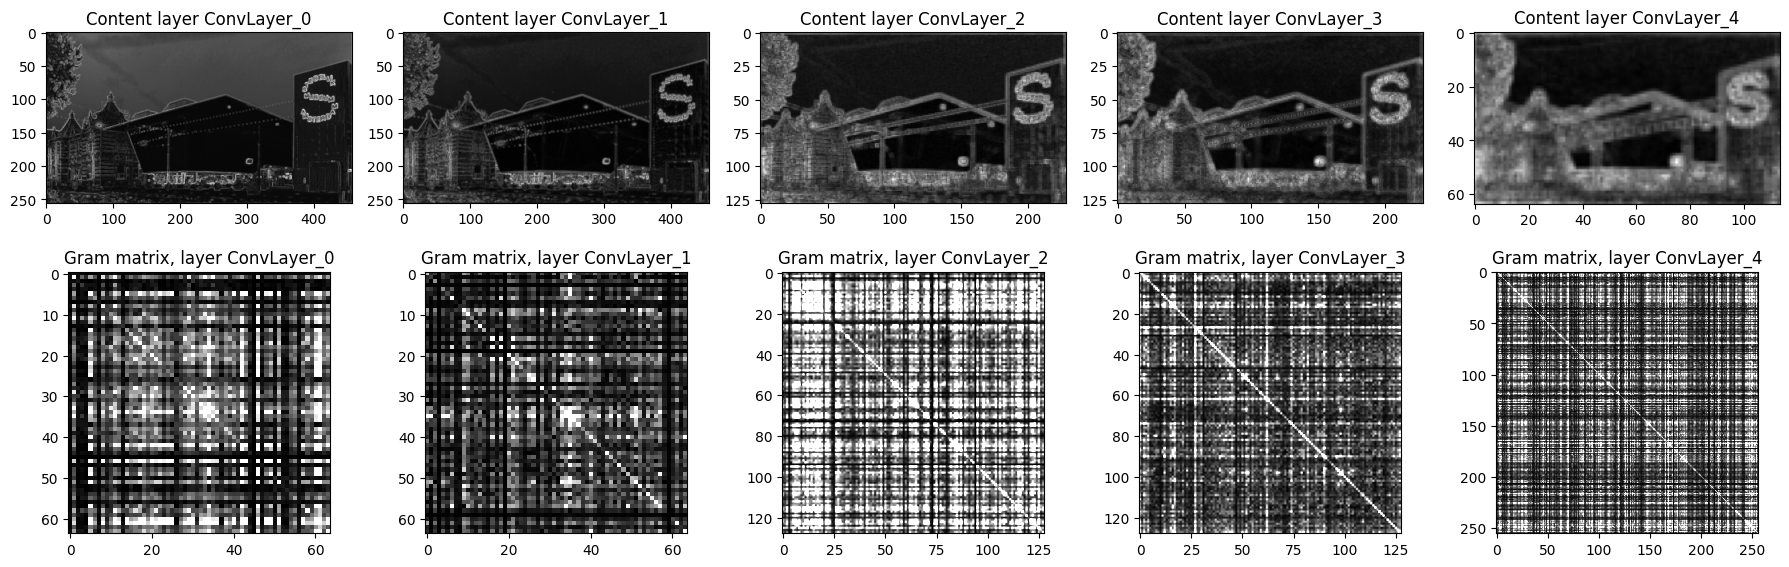

In [21]:
visualize_feature_maps(content_feature_maps, content_feature_names, 'Content')

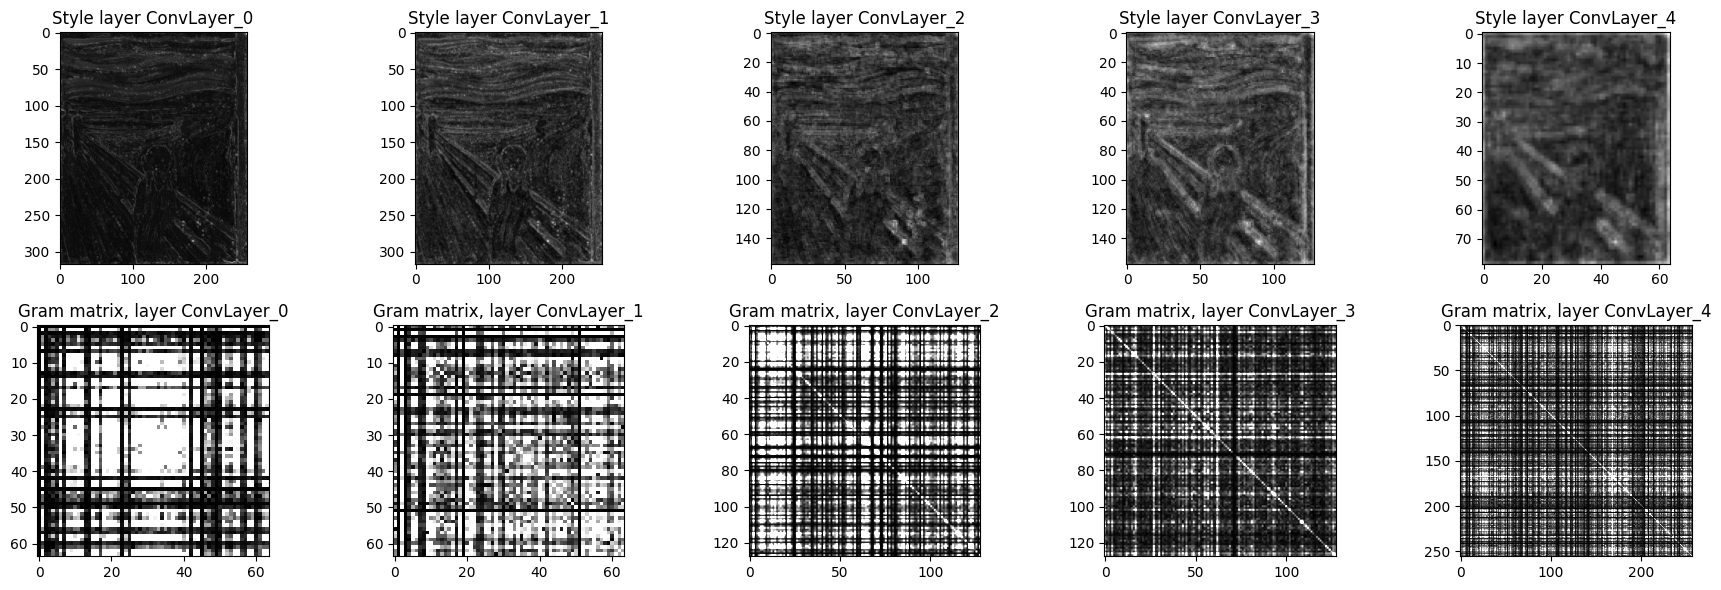

In [22]:
visualize_feature_maps(style_feature_maps, style_feature_names, 'Style')

In [23]:
# which layers to use
layers4content = [ 'ConvLayer_1', 'ConvLayer_4' ]
layers4style   = [ 'ConvLayer_1', 'ConvLayer_2', 'ConvLayer_3', 'ConvLayer_4', 'ConvLayer_5' ]
weights4style  = [      1       ,      .5      ,      .5      ,      .2      ,      .1       ]

target_img.requires_grad = True
styleScaling = 1e4

# number of epochs to train
numepochs = 1500

# optimizer for backprop
optimizer = torch.optim.RMSprop([target_img], lr=.005)

for _ in range(numepochs):

    # extract the target feature maps
    target_feature_maps, target_feature_names = get_feature_maps(target_img, net)

    # initialize the individual loss components
    style_loss = 0
    content_loss = 0

    # loop over layers
    for layeri in range(len(target_feature_names)):

        # compute the content loss
        if target_feature_names[layeri] in layers4content:
            content_loss += torch.mean( (target_feature_maps[layeri] - content_feature_maps[layeri]) ** 2 )

        # compute the style loss
        if target_feature_names[layeri] in layers4style:

            # Gram matrices
            Gtarget = gram_matrix(target_feature_maps[layeri])
            Gstyle  = gram_matrix(style_feature_maps[layeri])

            # compute their loss (de-weighted with increasing depth)
            style_loss += torch.mean( (Gtarget - Gstyle) ** 2 ) * weights4style[ layers4style.index( target_feature_names[layeri] ) ]

    # combined loss
    combined_loss = styleScaling * style_loss + content_loss

    # finally ready for backprop!
    optimizer.zero_grad()
    combined_loss.backward()
    optimizer.step()


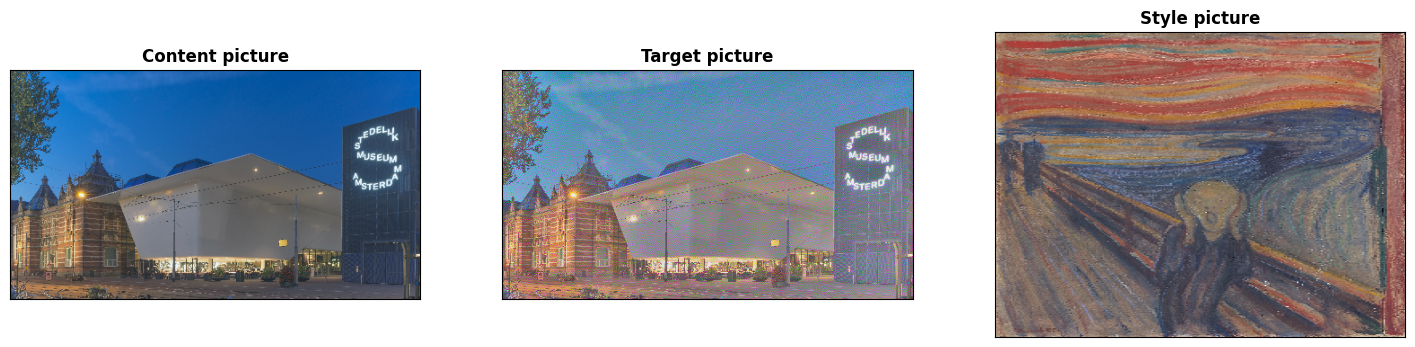

In [24]:
# visualize the generated pic
_, ax = plt.subplots(1, 3, figsize=(18,11), num='Applied Style Transfer')

pic = content_img.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture', fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target_img).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture', fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = style_img.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))
ax[2].imshow(pic, aspect=.6)
ax[2].set_title('Style picture', fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()
